In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np


import pandas as pd
import os


root = "/Users/zyxu/Documents/py/FM_weights"
os.chdir(root)


In [10]:
loaded_tensor = torch.load(f'{root}/output/4sets_intermediate_outputs.pth')
print(loaded_tensor.shape)

h_total = loaded_tensor

torch.Size([13, 256, 197, 192])


In [31]:
assert h_total.dim() == 4   #  [Layer, Batch*sets, T(Seq), D][13, 64, 197, 192]
L, B, T, D = h_total.shape  # [13, 64, 197, 192]

mu = h_total.mean(dim=(-2, -3))
print("mu.shape", mu.shape)

expanded_mu_pos = mu.unsqueeze(1).expand(-1, T, D)  # [Layer, T(Seq), D] [13,197,192]
print("expanded_mu_pos: ", expanded_mu_pos.shape)
pos = h_total.mean(1) - expanded_mu_pos  # [Layer, T(Seq), D] [13,97,192]


expanded_mu_ctx = mu.unsqueeze(1).expand(-1, B, D) # [Layer, Batch*sets, D] [13, 64 ,192]
print("expanded_mu_ctx: ", expanded_mu_ctx.shape)
ctx = h_total.mean(2) - expanded_mu_ctx # [Layer, Batch*sets, D] [13, 64 ,192]


expanded_pos = pos.unsqueeze(1).expand(-1, B, -1, -1)   #  [Layer, Batch*sets, T(Seq), D][13, 64, 197, 192]
expanded_ctx = ctx.unsqueeze(2).expand(-1, -1, T, -1)   #  [Layer, Batch*sets, T(Seq), D][13, 64, 197, 192]
expanded_mu_whole = mu.unsqueeze(1).unsqueeze(1).expand(-1, B, T, D) 
print(f"expanded_pos: {expanded_pos.shape}, expanded_ctx: {expanded_ctx.shape}, expanded_mu_whole: {expanded_mu_whole.shape}")

resid = h_total - expanded_mu_whole - expanded_pos - expanded_ctx      #  [Layer, Batch*sets, T(Seq), D][13, 64, 197, 192]
print(f"resid: {resid.shape}")


cvec = expanded_ctx + resid  #  [Layer, Batch*sets, T(Seq), D][13, 64, 197, 192]
print(f"cvec: {cvec.shape}")

mu.shape torch.Size([13, 192])
expanded_mu_pos:  torch.Size([13, 197, 192])
expanded_mu_ctx:  torch.Size([13, 256, 192])
expanded_pos: torch.Size([13, 256, 197, 192]), expanded_ctx: torch.Size([13, 256, 197, 192]), expanded_mu_whole: torch.Size([13, 256, 197, 192])
resid: torch.Size([13, 256, 197, 192])
cvec: torch.Size([13, 256, 197, 192])


In [32]:
np.allclose(h_total.mean(1).detach().numpy()[0] - expanded_mu_pos.detach().numpy()[0], h_total.mean(1).detach().numpy()[0] - mu.detach().numpy()[0])

True

In [44]:
np.allclose((cvec[0]).detach().numpy(), c)

True

In [42]:
np.allclose(expanded_pos[0].detach().numpy(), p_full)

True

In [43]:
np.allclose(mu[0].detach().numpy(), g)

True

In [47]:
np.allclose((cvec[0] + expanded_pos[0] + mu[0]).detach().numpy(), m)

True

In [53]:
np.allclose((cvec[0] + expanded_pos[0] + mu[0]).detach().numpy(), h_total[0].detach().numpy())

False

In [33]:
L, T, D = pos.shape
L, B, T, D = cvec.shape
nseq = B

In [34]:
l = 0
p = pos[l].detach().numpy()  # [T, C]
c = cvec[l].detach().numpy() # [B, T, C]
g = mu[l].detach().numpy()

p_full = np.stack([p for _ in range(nseq)])
p_full.shape

(256, 197, 192)

In [24]:
gg = torch.tensor(g).unsqueeze(0).unsqueeze(0).expand(256, 197, 192).numpy()

In [25]:
m = p_full + c + g
np.allclose(m, p_full + c + gg)

True

In [48]:
m2 = loaded_tensor[0].detach().numpy()
m2.shape

(256, 197, 192)

In [56]:
np.allclose(m,m2, atol = 1e-5)

True

In [57]:
m-m2

array([[[-3.7252903e-09,  0.0000000e+00,  0.0000000e+00, ...,
          0.0000000e+00, -9.3132257e-10,  0.0000000e+00],
        [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
          0.0000000e+00, -1.4901161e-08,  0.0000000e+00],
        [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
          0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
        ...,
        [ 0.0000000e+00, -1.4901161e-08,  0.0000000e+00, ...,
          0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
        [ 1.4901161e-08,  1.4901161e-08,  0.0000000e+00, ...,
          2.9802322e-08,  0.0000000e+00,  0.0000000e+00],
        [ 0.0000000e+00,  2.9802322e-08,  0.0000000e+00, ...,
          0.0000000e+00,  0.0000000e+00,  0.0000000e+00]],

       [[-3.7252903e-09,  0.0000000e+00,  0.0000000e+00, ...,
          0.0000000e+00, -9.3132257e-10,  1.8626451e-09],
        [ 2.9802322e-08,  0.0000000e+00,  0.0000000e+00, ...,
          1.4901161e-08, -1.4901161e-08,  0.0000000e+00],
        [ 2.9802322e-08, 

##### visz PCA

p shape:  (197, 192)


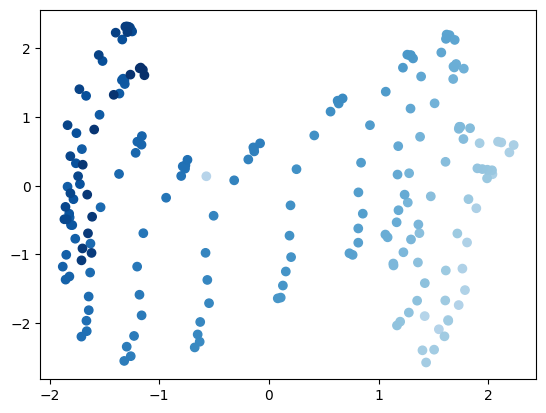

In [59]:
layer_idx = 0
p = pos[layer_idx].detach().numpy()

print("p shape: ", p.shape) # [197, 192]

# apply PCA
u, s, vt = np.linalg.svd(p)
proj_mat = vt[:2, :].T

# print("proj_mat shape: ", proj_mat.shape) # [192, 2]
pc = p @ proj_mat

# print("pc shape: ", pc.shape) # [197, 2]

colors_blue = [plt.cm.Blues(x) for x in np.linspace(0.3, 1, T)]


# Create a figure and axis
fig, ax = plt.subplots()
ax.scatter(pc[:, 0], pc[:, 1], c=colors_blue, label="pos")

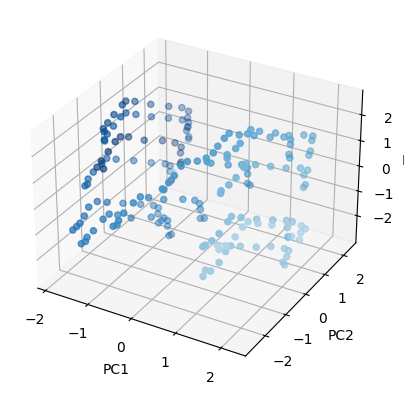

In [60]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming p is your data matrix and T is some scalar for color

# apply PCA
u, s, vt = np.linalg.svd(p)
proj_mat = vt[:3, :].T  # Now taking the first 3 PCs

# print("proj_mat shape: ", proj_mat.shape) # [192, 3] (assuming your data has 192 features)
pc = p @ proj_mat

# print("pc shape: ", pc.shape) # [197, 3] (assuming you have 197 samples)

colors_blue = [plt.cm.Blues(x) for x in np.linspace(0.3, 1, T)]

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')  # Create a 3D axis
ax.scatter(pc[:, 0], pc[:, 1], pc[:, 2], c=colors_blue, label="pos")
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')

plt.show()
